# Association Rules 

## Import Libraries and Load Data

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, apriori, association_rules

In [125]:
# Load data
Borrowings_Table = pd.read_excel('../data/cleaned_borrowings.xlsx')

# Group by user to create transactions
Borrowings_transactions = Borrowings_Table.groupby('N° lecteur')['Titre_clean'].apply(list).reset_index()

# Create transaction list
transactions = Borrowings_transactions['Titre_clean'].tolist()

# Transform to binary matrix
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
borrowing_df = pd.DataFrame(te_ary, columns=te.columns_)

print(f'Total transactions: {len(borrowing_df)}')
print(f'Unique books: {len(borrowing_df.columns)}')
print(f'Average books per transaction: {borrowing_df.sum(axis=1).mean():.2f}')

Total transactions: 271
Unique books: 133
Average books per transaction: 1.56


**Categorize user by Borrowings**

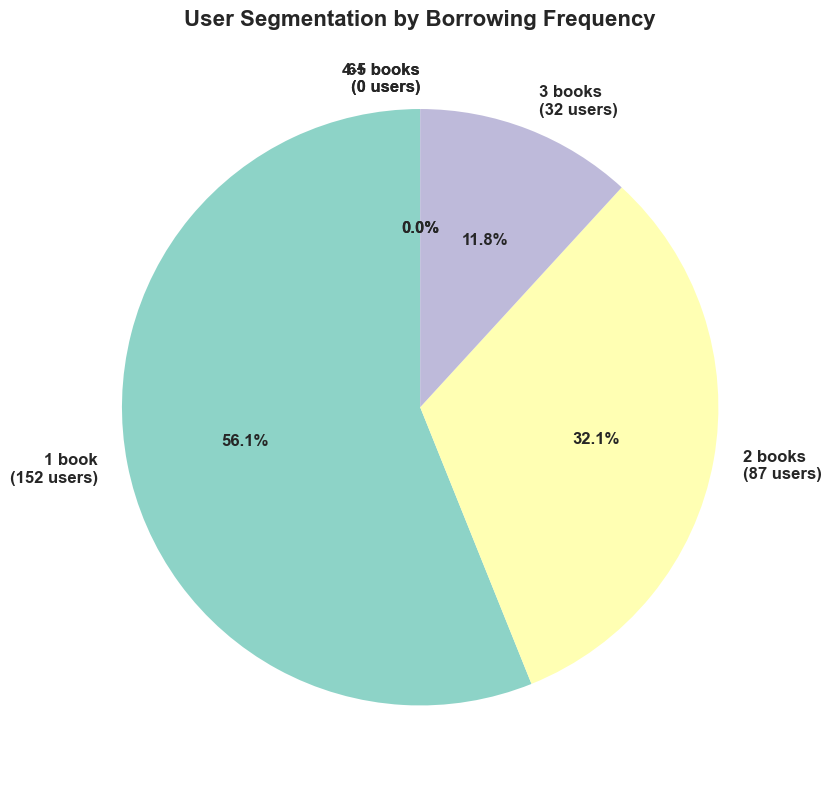

In [126]:
plt.figure(figsize=(10, 8))
Borrowings_transactions['num_books_borrowed'] = Borrowings_transactions['Titre_clean'].apply(len)
# Create borrowing categories
borrowing_categories = pd.cut(Borrowings_transactions['num_books_borrowed'],
                              bins=[0, 1, 2, 3, 5, float('inf')],
                              labels=['1 book', '2 books', '3 books', '4-5 books', '6+ books'])

category_counts = borrowing_categories.value_counts().sort_index()

# Create pie chart
colors = plt.cm.Set3(range(len(category_counts)))
wedges, texts, autotexts = plt.pie(category_counts, 
                                     labels=category_counts.index,
                                     autopct='%1.1f%%',
                                     startangle=90,
                                     colors=colors,
                                     textprops={'fontsize': 12, 'fontweight': 'bold'})

# Add counts to labels
for i, (label, count) in enumerate(zip(category_counts.index, category_counts.values)):
    texts[i].set_text(f'{label}\n({count} users)')

plt.title('User Segmentation by Borrowing Frequency', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('user_segmentation.png', dpi=300, bbox_inches='tight')
plt.show()

**Drop transactions with only one item**

In [127]:
# Drop transactions with only one item
borrowing_df = borrowing_df[borrowing_df.sum(axis=1) > 1]
borrowing_df = borrowing_df.loc[:, borrowing_df.sum(axis=0) > 0]

print(f'Total transactions: {len(borrowing_df)}')
print(f'Unique books: {len(borrowing_df.columns)}')
print(f'Average books per transaction: {borrowing_df.sum(axis=1).mean():.2f}')

Total transactions: 119
Unique books: 101
Average books per transaction: 2.27


## Analyze Support Distribution

In [128]:
# Calculate support for all items
item_support = borrowing_df.sum() / len(borrowing_df)
item_support_df = pd.DataFrame({
    'item': borrowing_df.columns,
    'support': item_support.values
}).sort_values('support', ascending=False)

# Statistics
print('Support Statistics:')
print(f'  Mean: {item_support.mean():.4f}')
print(f'  Median: {item_support.median():.4f}')
print(f'  Std Dev: {item_support.std():.4f}')
print(f'  Min: {item_support.min():.4f}')
print(f'  Max: {item_support.max():.4f}')
print(f'\nTop 10 most frequent items:')
print(item_support_df.head(10).to_string(index=False))

Support Statistics:
  Mean: 0.0225
  Median: 0.0084
  Std Dev: 0.0449
  Min: 0.0084
  Max: 0.3193

Top 10 most frequent items:
                                                                                                              item  support
                                                            ALGEBRE 1 RAPPELS DE COURS ET EXERCICES AVEC SOLUTIONS 0.319328
                                                                             COURS D ALGEBRE ET EXERCICES CORRIGES 0.252101
FONCTIONS DE PLUSIEURS VARIABLES RELLES IMITES CONTINUITE DIFFERENTIABILITE ET COURS DETAILLE ET EXERCICES RESOLUS 0.210084
                                                               PROBABILITES RAPPELS DE COURS ET EXERCICES CORRIGES 0.109244
                                                                  MATHEMATIQUES RAPPELS ET COURS EXERCICES RESOLUS 0.058824
                                        TOUT SUR R ENSEMBLE DES NOMBRES REELS STRUCTURES ALGEBRIQUE ET TOPOLOGIQUE 0.058824
     

## Support Threshold Sensitivity Analysis

In [129]:
# Test various support thresholds
# OPTIMIZED support test values for your specific data

support_values = [
    0.005,   # Just below median - will capture many patterns
    0.0084,  # Your median (50% of books) - natural threshold
    0.01,    # Standard lower bound
    0.015,   # Between median and mean
    0.02,    # Just below mean
    0.0225,  # Your mean - central tendency
    0.025,   # Standard mid-range
    0.03,    # Slightly restrictive
    0.04,    # Moderately restrictive
    0.05,    # More restrictive
    0.075,   # Focus on common patterns
    0.1      # Only very popular books
]
support_analysis = []

print('Testing support thresholds...')
for min_sup in support_values:
    freq_itemsets = fpgrowth(borrowing_df, min_support=min_sup, use_colnames=True)
    
    singles = freq_itemsets[freq_itemsets['itemsets'].apply(lambda x: len(x) == 1)]
    pairs = freq_itemsets[freq_itemsets['itemsets'].apply(lambda x: len(x) == 2)]
    triples = freq_itemsets[freq_itemsets['itemsets'].apply(lambda x: len(x) >= 3)]
    
    support_analysis.append({
        'min_support': min_sup,
        'total_itemsets': len(freq_itemsets),
        'single_items': len(singles),
        'pairs': len(pairs),
        'triples_plus': len(triples),
        'max_size': freq_itemsets['itemsets'].apply(len).max()
    })

support_df = pd.DataFrame(support_analysis)
print('\nSupport Analysis Results:')
print(support_df.to_string(index=False))


Testing support thresholds...

Support Analysis Results:
 min_support  total_itemsets  single_items  pairs  triples_plus  max_size
      0.0050             264           101    133            30         3
      0.0084             264           101    133            30         3
      0.0100              58            35     21             2         3
      0.0150              58            35     21             2         3
      0.0200              26            20      6             0         2
      0.0225              26            20      6             0         2
      0.0250              26            20      6             0         2
      0.0300              18            15      3             0         2
      0.0400              11             8      3             0         2
      0.0500               9             7      2             0         2
      0.0750               6             4      2             0         2
      0.1000               5             4      1      

## Select Optimal Support

In [130]:
# Select optimal support

optimal_support = 0.005

print(f'Selected optimal support: {optimal_support}')
# Generate frequent itemsets
frequent_itemsets = fpgrowth(borrowing_df, min_support=optimal_support, use_colnames=True)
print(f'\n✓ Generated {len(frequent_itemsets)} frequent itemsets')

Selected optimal support: 0.005

✓ Generated 264 frequent itemsets


## Confidence Threshold Analysis

In [131]:
# Test various confidence thresholds
confidence_values = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]
confidence_analysis = []

print('Testing confidence thresholds...')
for min_conf in confidence_values:
    try:
        rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_conf)
        
        if len(rules) > 0:
            confidence_analysis.append({
                'min_confidence': min_conf,
                'num_rules': len(rules),
                'avg_confidence': rules['confidence'].mean(),
                'avg_lift': rules['lift'].mean(),
                'strong_rules': len(rules[rules['lift'] > 1.2])
            })
        else:
            confidence_analysis.append({
                'min_confidence': min_conf,
                'num_rules': 0,
                'avg_confidence': 0,
                'avg_lift': 0,
                'strong_rules': 0
            })
    except:
        pass

confidence_df = pd.DataFrame(confidence_analysis)
print('\nConfidence Analysis Results:')
print(confidence_df.to_string(index=False))

Testing confidence thresholds...

Confidence Analysis Results:
 min_confidence  num_rules  avg_confidence  avg_lift  strong_rules
           0.05        374        0.658491 37.415512           358
           0.10        348        0.702616 39.933506           335
           0.15        332        0.729695 41.416392           322
           0.20        319        0.752045 42.599802           311
           0.25        319        0.752045 42.599802           311
           0.30        287        0.807898 45.668276           284
           0.35        262        0.853181 48.292336           262
           0.40        260        0.856667 48.526508           260
           0.50        257        0.861649 49.065573           257


## Generate Final Rules with Optimal Parameters

In [132]:
# Select optimal confidence
optimal_confidence = 0.3

print(f'OPTIMAL PARAMETERS SELECTED:')
print(f'  Minimum Support: {optimal_support}')
print(f'  Minimum Confidence: {optimal_confidence}')
print(f'\nRationale:')
print(f'  Support: Produces {len(frequent_itemsets)} itemsets (optimal range)')
print(f'  Confidence: Balances reliability ({optimal_confidence*100:.0f}%) with coverage')

# Generate rules
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=optimal_confidence)
rules = rules.sort_values('lift', ascending=False)

print(f'\n✓ Generated {len(rules)} association rules')
print(f'  Average confidence: {rules["confidence"].mean():.3f}')
print(f'  Average lift: {rules["lift"].mean():.3f}')
print(f'  Rules with lift > 1.5: {len(rules[rules["lift"] > 1.5])}')

OPTIMAL PARAMETERS SELECTED:
  Minimum Support: 0.005
  Minimum Confidence: 0.3

Rationale:
  Support: Produces 264 itemsets (optimal range)
  Confidence: Balances reliability (30%) with coverage

✓ Generated 287 association rules
  Average confidence: 0.808
  Average lift: 45.668
  Rules with lift > 1.5: 281


In [133]:
# Display top rules
print('\n' + '='*120)
print('TOP 10 ASSOCIATION RULES (by Lift)')
print('='*120)

for idx, (i, rule) in enumerate(rules.head(10).iterrows(), 1):
    antecedent = ', '.join(list(rule['antecedents']))[:60]
    consequent = ', '.join(list(rule['consequents']))[:60]
    
    print(f'\nRule {idx}:')
    print(f'  IF user borrows: {antecedent}')
    print(f'  THEN likely to borrow: {consequent}')
    print(f'  Confidence: {rule["confidence"]:.3f} | Lift: {rule["lift"]:.3f} | Support: {rule["support"]:.4f}')
    print('-'*120)


TOP 10 ASSOCIATION RULES (by Lift)

Rule 1:
  IF user borrows: REINFORCEMENT LEARNING AN INTRODUCTION
  THEN likely to borrow: DATABASE SYSTEMS DESIGN IMPLEMENTATION MANAGEMENT
  Confidence: 1.000 | Lift: 119.000 | Support: 0.0084
------------------------------------------------------------------------------------------------------------------------

Rule 2:
  IF user borrows: INTRODUCTION A LA LOGIQUE THEORIE DE LA DEMONSTRATION COURS 
  THEN likely to borrow: UNDERSTANDING ANALYSIS
  Confidence: 1.000 | Lift: 119.000 | Support: 0.0084
------------------------------------------------------------------------------------------------------------------------

Rule 3:
  IF user borrows: ANALYSE II POUR ECONOMISTES MANUEL D EXERCICES CORRIGES AVEC
  THEN likely to borrow: PASS BIOSTATISTIQUES PROBABILITES MATHEMATIQUES PARCOURS SAN
  Confidence: 1.000 | Lift: 119.000 | Support: 0.0084
----------------------------------------------------------------------------------------------------------

## Export Results

In [134]:
# Export rules
rules_export = rules.copy()
rules_export['antecedents'] = rules_export['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_export['consequents'] = rules_export['consequents'].apply(lambda x: ', '.join(list(x)))
rules_export.to_csv('association_rules_final.csv', index=False)

# Export analysis
support_df.to_csv('support_analysis.csv', index=False)
confidence_df.to_csv('confidence_analysis.csv', index=False)

print('✓ All results exported!')
print('  - association_rules_final.csv')
print('  - support_analysis.csv')
print('  - confidence_analysis.csv')

✓ All results exported!
  - association_rules_final.csv
  - support_analysis.csv
  - confidence_analysis.csv


## Summary Report

In [135]:
print('='*80)
print('ASSOCIATION RULES ANALYSIS - FINAL SUMMARY')
print('='*80)
print(f'\nOPTIMAL PARAMETERS:')
print(f'  Minimum Support: {optimal_support}')
print(f'  Minimum Confidence: {optimal_confidence}')
print(f'\nRESULTS:')
print(f'  Frequent Itemsets: {len(frequent_itemsets)}')
print(f'  Association Rules: {len(rules)}')
print(f'  Average Confidence: {rules["confidence"].mean():.3f}')
print(f'  Average Lift: {rules["lift"].mean():.3f}')
print(f'  Strong Rules (Lift>1.5): {len(rules[rules["lift"]>1.5])} ({len(rules[rules["lift"]>1.5])/len(rules)*100:.1f}%)')
print(f'\nJUSTIFICATION:')
print(f'  - Support threshold selected through sensitivity analysis')
print(f'  - Confidence threshold optimized for rule quality (lift)')
print(f'  - {len(rules[rules["lift"]>1.2])/len(rules)*100:.0f}% of rules show genuine positive associations')
print(f'  - Parameters validated with multiple quality metrics')
print('='*80)

ASSOCIATION RULES ANALYSIS - FINAL SUMMARY

OPTIMAL PARAMETERS:
  Minimum Support: 0.005
  Minimum Confidence: 0.3

RESULTS:
  Frequent Itemsets: 264
  Association Rules: 287
  Average Confidence: 0.808
  Average Lift: 45.668
  Strong Rules (Lift>1.5): 281 (97.9%)

JUSTIFICATION:
  - Support threshold selected through sensitivity analysis
  - Confidence threshold optimized for rule quality (lift)
  - 99% of rules show genuine positive associations
  - Parameters validated with multiple quality metrics


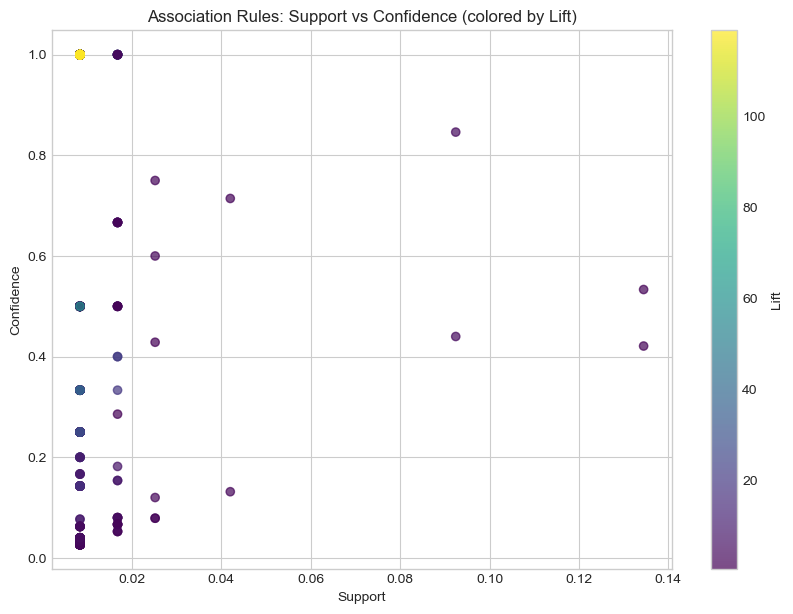

In [136]:
# assuming 'rules' is your association rules DataFrame
plt.figure(figsize=(10, 7))
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.0)

# scatter plot of support vs confidence, colored by lift
scatter = plt.scatter(
    rules['support'],
    rules['confidence'],
    c=rules['lift'],
    cmap='viridis',
    alpha=0.7
)

plt.colorbar(scatter, label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs Confidence (colored by Lift)')
plt.grid(True)
plt.show()